In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import glob
import re
from matplotlib.patches import Rectangle

In [319]:
def multi_index_slice_to_average_rate(x):
    sliced_values = data.loc[x, :]
    sliced_values_of_interest = sliced_values.loc[:, 'cases_per_1M_people_per_100k_tests']
    # x is a tuple of the form ('country', slice(A,B))
    if len(sliced_values_of_interest) == 0:
        return np.nan
    if x[1].start is None:
        avg_case_rate = ((1/len(sliced_values_of_interest))
                          *np.log((sliced_values_of_interest.iloc[-1]/sliced_values_of_interest.iloc[:-1].mean())))
    else:
        avg_case_rate = ((1/len(sliced_values_of_interest))
                          *np.log((sliced_values_of_interest.iloc[1:].mean()/sliced_values_of_interest.iloc[0])))        
    return avg_case_rate

In [581]:
def multiindex_response_date_to_average_rates(x):
    country = x[0]
    date = x[1]
    before_slice = pd.IndexSlice[date-pd.Timedelta(days=14):date-pd.Timedelta(days=1)]
    after_slice =  pd.IndexSlice[date+pd.Timedelta(days=1):date+pd.Timedelta(days=14)]
    cutoff = data.loc[(country, date), 'cases_per_1M_people_per_100k_tests']
    before_df = data.loc[(country, before_slice), 'cases_per_1M_people_per_100k_tests']
    after_df = data.loc[(country, after_slice), 'cases_per_1M_people_per_100k_tests']
    avg_rate_before = (1./14.)*np.log(cutoff/before_df.mean())
    avg_rate_after = (1./14.)*np.log(after_df.mean()/cutoff)
    return avg_rate_before - avg_rate_after

To do list:

Filter government response data to find when each measure was enacted for each country.
Get population and testing data for weights
Calculate average growth rates before and after each government response.
This is done by calculating the rates using three data points for each quarantine measure.
The date of first case (subscript $i$), the date of the mandate (subscript $m$), 
and the most recent date or date that the response ended (subscript $f$).
On these two different intervals, calculate the rates before and after which are given by
    
\begin{align}
r_{\text{before}} &= \frac{1}{\Delta t_{mi}}\log(\frac{\phi_m}{\phi_i}) \\
r_{\text{after}} &= \frac{1}{\Delta t_{fm}}\log(\frac{\phi_f}{\phi_m})\,,
\end{align}

where $\phi_j$ is the number of cases per population per tests on a given day, $t = t_j$ 

4. TWO_WAY ANOVA where countries are FACTOR A, response type is FACTOR B and BEFORE AFTER are the N's.

To perform these calculations, need the dates which define the before and after intervals (unique to each country
and response type pair, from https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker) and need the cases per population per tests. The cases per population is
given in one of the data sets (original testing data, has too many missing values) https://ourworldindata.org/covid-testing . The (more reliable) number of tests is given in the dataset acquired at https://finddx.shinyapps.io/FIND_Cov_19_Tracker/

The property that makes this process very tricky is that all three datasets have variable time series: that is, they vary between datasets, between countries and even between the dates themselves. What I mean by the last part is that sometimes accurate testing numbers were not recorded and so there are either missing values or horizontal testing curves for whatever period of time. My choice for how to handle this difficulty is to use pandas DataFrames, specifically which a multi level index where the levels correspond to the countries and then the dates of the time series. 

Import the .csv file that contains information on government responses and action events.

In [3]:
response_df = pd.read_csv('./OxCGRT_Download_250420_012832_Full.csv')
response_df.tail()

,CountryName,CountryCode,Date,S1_School closing,S1_IsGeneral,S1_Notes,S2_Workplace closing,S2_IsGeneral,S2_Notes,S3_Cancel public events,...,S11_Notes,S12_Testing framework,S12_Notes,S13_Contact tracing,S13_Notes,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,Unnamed: 39
17277,Kosovo,RKS,20200419,2.0,1.0,NaN,2.0,0.0,NaN,2.0,...,NaN,1.0,NaN,1.0,NaN,510.0,12.0,90.48,90.48,\t
17278,Kosovo,RKS,20200420,2.0,1.0,NaN,2.0,0.0,NaN,2.0,...,NaN,1.0,NaN,1.0,NaN,510.0,12.0,90.48,90.48,\t
17279,Kosovo,RKS,20200421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,510.0,12.0,NaN,90.48,\t
17280,Kosovo,RKS,20200422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,510.0,12.0,NaN,90.48,\t
17281,Kosovo,RKS,20200423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,510.0,12.0,NaN,90.48,\t


Slice out all "notes" and targeted vs. general response columns. This currently goes beyond what I want to do. Also
merge day, month, year data into single date timestamp

In [4]:
response_df_edit = response_df.copy()
for x in response_df.columns:
    if (x.count('Notes')>0) | (x.count('IsGeneral')>0):
        response_df_edit.drop(columns=x, inplace=True)
        
response_df_edit.drop(columns='Unnamed: 39', inplace=True)
response_df_edit.loc[:, 'Date'] = pd.to_datetime(response_df_edit.Date, format='%Y%m%d', errors='coerce')

For WHATEVER reason, I cannot use idxmin or idxmax to get the correct date when the date is the index, but
if DATE is kept as a column I can use max or min. 

Two-way ANOVA: Factor A will be quarantine type? Factor B is Country? Only count countries where
quarantine has been active for 2 weeks consectutively. The trials will be the time series. (weighted by population, and number of tests).

Take a subset of data which has implemented all quarantine measures that will be tested. 
The quantifiable measure will be 


OK: averaging over the time series is dubious because of confounding factors. 

In [5]:
group_by_country = response_df_edit.groupby(by=['CountryName','Date']).sum()

In [6]:
group_by_country.columns = ['_'.join(y.split(' ')) for y in [x.split('_')[-1] for x in group_by_country.columns.tolist()]]
group_by_country.head()

School_closing  Workplace_closing  \
CountryName Date                                            
Afghanistan 2020-01-01             0.0                0.0   
            2020-01-02             0.0                0.0   
            2020-01-03             0.0                0.0   
            2020-01-04             0.0                0.0   
            2020-01-05             0.0                0.0   

                        Cancel_public_events  Close_public_transport  \
CountryName Date                                                       
Afghanistan 2020-01-01                   0.0                     0.0   
            2020-01-02                   0.0                     0.0   
            2020-01-03                   0.0                     0.0   
            2020-01-04                   0.0                     0.0   
            2020-01-05                   0.0                     0.0   

                        Public_information_campaigns  \
CountryName Date                                       
Afghanistan 2020-01-01                           0.0   
            2020-01-02                           0.0   
            2020-01-03                           0.0   
            2020-01-04                           0.0   
            2020-01-05                           0.0   

                        Restrictions_on_internal_movement  \
CountryName Date                                            
Afghanistan 2020-01-01                                0.0   
            2020-01-02                                0.0   
            2020-01-03                                0.0   
            2020-01-04                                0.0   
            2020-01-05                                0.0   

                        International_travel_controls  Fiscal_measures  \
CountryName Date                                                         
Afghanistan 2020-01-01                            0.0              0.0   
            2020-01-02                            0.0              0.0   
            2020-01-03                            0.0              0.0   
            2020-01-04                            0.0              0.0   
            2020-01-05                            0.0              0.0   

                        Monetary_measures  \
CountryName Date                            
Afghanistan 2020-01-01                0.0   
            2020-01-02                0.0   
            2020-01-03                0.0   
            2020-01-04                0.0   
            2020-01-05                0.0   

                        Emergency_investment_in_health_care  \
CountryName Date                                              
Afghanistan 2020-01-01                                  0.0   
            2020-01-02                                  0.0   
            2020-01-03                                  0.0   
            2020-01-04                                  0.0   
            2020-01-05                                  0.0   

                        Investment_in_Vaccines  Testing_framework  \
CountryName Date                                                    
Afghanistan 2020-01-01                     0.0                0.0   
            2020-01-02                     0.0                0.0   
            2020-01-03                     0.0                0.0   
            2020-01-04                     0.0                0.0   
            2020-01-05                     0.0                0.0   

                        Contact_tracing  ConfirmedCases  ConfirmedDeaths  \
CountryName Date                                                           
Afghanistan 2020-01-01              0.0             0.0              0.0   
            2020-01-02              0.0             0.0              0.0   
            2020-01-03              0.0             0.0              0.0   
            2020-01-04              0.0             0.0              0.0   
            2020-01-05              0.0             0

Because each computation requires its own unique slice, with a multiindex no less, I find it easiest
to create a DataFrame whose values are pandas multislice elements using pandas IndexSlice objects. 
These values cannot be passed at once to the testing multiindex array, but it was designed to take advantage of the .apply method. 

In [7]:
all_responses = group_by_country.iloc[:, [0, 1, 2, 3, 5, 6]]
country_list = []
slice_list = []

for j, (country, country_df) in enumerate(all_responses.groupby(level=0)):
    active_dates = country_df.replace(to_replace=0., value=np.nan)
    country_list += [country]
    before_list = []
    after_list = []
    for i, single_response in enumerate(active_dates.columns):
        effective_range = active_dates[single_response].dropna(axis=0)
        before = effective_range.reset_index().Date.min()
        after = effective_range.reset_index().Date.max()
        slice_list += [pd.IndexSlice[:before], pd.IndexSlice[before:after]]   
        
before_after_columns = np.array([[x+'_before', x+'_after'] for x in all_responses.columns.tolist()]).ravel()
enacted_ended_df = pd.DataFrame(np.array(slice_list).reshape(len(country_list), -1), index=country_list, columns=before_after_columns)

In [583]:
all_responses = group_by_country.iloc[:, [0, 1, 2, 3, 5, 6]]
country_list = []
slice_list = []

for j, (country, country_df) in enumerate(all_responses.groupby(level=0)):
    active_dates = country_df.replace(to_replace=0., value=np.nan)
    country_list += [country]
    before_list = []
    after_list = []
    for i, single_response in enumerate(active_dates.columns):
        effective_range = active_dates[single_response].dropna(axis=0)
        before = effective_range.reset_index().Date.min()
#         after = effective_range.reset_index().Date.max()
        slice_list += [before]   
        
enacted_ended_df = pd.DataFrame(np.array(slice_list).reshape(len(country_list), -1), index=country_list, columns=all_responses.columns)

In [584]:
all_responses = group_by_country.iloc[:, [0, 1, 2, 3, 5, 6]]
country_list = []
minmax_list = []
for j, (country, country_df) in enumerate(all_responses.groupby(level=0)):
    active_dates = country_df.replace(to_replace=0., value=np.nan)
    country_list += [country]
    for i, single_response in enumerate(active_dates.columns):
        effective_range = active_dates[single_response].dropna(axis=0)
        before = effective_range.reset_index().Date.min()
        after = effective_range.reset_index().Date.max()
        minmax_list += [before, after]   

start_end_columns = np.array([[x+'_start', x+'_end'] for x in all_responses.columns.tolist()]).ravel()
start_end_df = pd.DataFrame(np.array(minmax_list).reshape(len(country_list), -1), index=country_list, columns=start_end_columns)

In order to incorporate the largest segment of the population, but remove all missing values, drop the
public transport columns and then drop the remaining countries with missing values.  

In [604]:
start_end_filtered_df = start_end_df.drop(columns=['Close_public_transport_start','Close_public_transport_end']).dropna(axis=0)
filtered_countries = start_end_filtered_df.index
enacted_ended_filtered_df = enacted_ended_df.drop(columns=['Close_public_transport']).loc[filtered_countries, :]

to be able to use apply later, zip the slices with the country names so that they look like multiindex slices

Can't do ANOVA on missing values, drop them; this has ramifications in the future of filtering countries.

There are a number of countries with mismatched labels (different data sources), correct these manually. 

The original numbers are in units of thousands of people

In [605]:
popdat = pd.read_csv('popdat.csv')#.set_index('Country')
popdat.loc[:, 'pop2020'] = 1000*popdat.loc[:, 'pop2020']
popdat = popdat.set_index('name')
popdat.index.name = 'country'

Because I have three different data sources for the population data, government response data, and testing data,
I first take the intersection of the countries which exist in all three data sets.

In [606]:
#popdat.index.intersection(start_end_filtered_df.index).intersection(testing_multiindex_df.index.get_level_values(level=0).unique())

Next, I need to create a strategy for how to account for missing test values (i.e. when there are cases but no tests, presumably this is either a lack of reporting or the "confirmed" cases are via diagnosis rather than explicit testing).

There are two "types" of missing test values: those from errors in reporting and those from confirmation of cases via diagnosis. I distinguish between these two types via the following: errors in reporting occur when there are gaps in the testing data after the date of the first known test. The second type occurs when there are known or confirmed cases but no testing data yet exists. To account for the first type I will use forward filling, as to not overestimate 


The second part of the weighting process is by the testing numbers, as the number of cases will go up if you
test more.

Import the new testing data (much better), but still use the old dataset because it has cases normalized by population.

In [607]:
mismatch_labels_bad = ['Lao People\'s Democratic Republic', 'Mainland China','Occupied Palestinian Territory','Republic of Korea','The Gambia', 'UK', 'USA','Iran (Islamic Republic of)']
mismatch_labels_good = ['Laos','China','Palestine','South Korea','Gambia','United Kingdom', 'United States','Iran']

In [608]:
test_and_case_df = pd.read_csv('./covid-19-data/owid-covid-data.csv')
# Convert "date" column to an actual datetime variable. 
test_and_case_df.loc[:, 'date'] = pd.to_datetime(test_and_case_df.loc[:, 'date'])
test_and_case_df.loc[:,'location'] = test_and_case_df.loc[:,'location'].replace(to_replace=mismatch_labels_bad, value=mismatch_labels_good)

testing_df = pd.read_csv('./new_covid_testing/Tests.csv')
testing_df.loc[:, 'date'] = pd.to_datetime(testing_df.loc[:, 'date'])
testing_df.loc[:,'country'] = testing_df.loc[:,'country'].replace(to_replace=mismatch_labels_bad, value=mismatch_labels_good)
testing_df = testing_df.set_index('country')
test_and_case_df = test_and_case_df.set_index('location')
testing_df.index.name = 'Country'
test_and_case_df.index.name = 'Country'

In [609]:
final_country_index = enacted_ended_filtered_df.index.intersection(testing_df.index.intersection(test_and_case_df.index)).unique()
# no case data?
final_country_index = final_country_index.drop('Hong Kong')

The pruned response data has 122 countries and the testing data has 206, the intersection : 94.
These 94 countries still account for 6.6 billion people, notable missing entries are: Ethiopia, Iran. Congo, United Kingdom,
dropped because they had missing values in governement response data; i.e. they did not take all considered actions. 

In [610]:
case_df = test_and_case_df.loc[final_country_index, :]
test_df = testing_df.loc[final_country_index, :]
response_df = start_end_filtered_df.loc[final_country_index, :]
case_df.loc[:, 'population'] = test_df.loc[:, 'population'].drop_duplicates()

In [611]:
first_case_dates = case_df.reset_index().set_index(['Country','date']).total_cases.replace(to_replace=0,value=np.nan).dropna().reset_index(level=1).groupby(level=0).date.min()

min_response_dates = response_df.min(axis=1)

tmp = response_df.copy()
dt = pd.DataFrame(np.tile(first_case_dates.values.reshape(-1,1),(1, response_df.shape[1])))
diff_df = tmp - np.tile(first_case_dates.values.reshape(-1,1),(1, response_df.shape[1]))
num_miss=diff_df.where(diff_df > pd.Timedelta(days=0)).isna().sum(1).sort_values(ascending=False)
countries_with_cases_before_responses = num_miss.where(num_miss==0).dropna().index

In [636]:
case_df = case_df.loc[countries_with_cases_before_responses, :]
test_df = testing_df.loc[countries_with_cases_before_responses, :]
response_df = start_end_filtered_df.loc[countries_with_cases_before_responses, :].sort_index()

To make my life easier, I'm only taking data which had cases before all government mandates so the rates before and after are well defined. We can think of these as being "late responders"

In [613]:
case_multiindex_df = case_df.set_index([case_df.index,'date']).sort_index()
case_multiindex_df.index.names = ['Country','Date']

test_multiindex_df = test_df.set_index([test_df.index,'date']).sort_index()
test_multiindex_df = test_multiindex_df.drop(columns='population')
test_multiindex_df.index.names = ['Country','Date']

In [672]:
tmp = enacted_ended_filtered_df.loc[countries_with_cases_before_responses, :].sort_index()
response_multiindex_df = tmp.copy()
response_multiindex_df = pd.DataFrame([list(zip(response_multiindex_df.index.tolist(), response_multiindex_df.loc[:, c].tolist())) for c in response_multiindex_df.columns]).transpose()
response_multiindex_df.index=tmp.index
response_multiindex_df.columns=tmp.columns
response_multiindex_df.head()

,School_closing,Workplace_closing,Cancel_public_events,Restrictions_on_internal_movement,International_travel_controls
Afghanistan,"(Afghanistan, 2020-03-14 00:00:00)","(Afghanistan, 2020-03-26 00:00:00)","(Afghanistan, 2020-03-01 00:00:00)","(Afghanistan, 2020-03-24 00:00:00)","(Afghanistan, 2020-03-02 00:00:00)"
Argentina,"(Argentina, 2020-03-16 00:00:00)","(Argentina, 2020-03-16 00:00:00)","(Argentina, 2020-03-13 00:00:00)","(Argentina, 2020-03-20 00:00:00)","(Argentina, 2020-03-11 00:00:00)"
Australia,"(Australia, 2020-03-22 00:00:00)","(Australia, 2020-03-24 00:00:00)","(Australia, 2020-03-16 00:00:00)","(Australia, 2020-03-19 00:00:00)","(Australia, 2020-02-01 00:00:00)"
Austria,"(Austria, 2020-03-16 00:00:00)","(Austria, 2020-03-12 00:00:00)","(Austria, 2020-03-11 00:00:00)","(Austria, 2020-03-13 00:00:00)","(Austria, 2020-03-09 00:00:00)"
Bahrain,"(Bahrain, 2020-02-26 00:00:00)","(Bahrain, 2020-03-24 00:00:00)","(Bahrain, 2020-03-18 00:00:00)","(Bahrain, 2020-03-25 00:00:00)","(Bahrain, 2020-03-10 00:00:00)"


In [662]:
data = case_multiindex_df.join(test_multiindex_df, lsuffix='_x', rsuffix='_y').sort_index(axis=1, ascending=False)

To ensure that total cases is a cumulative variable, replace zeros with np.nan and then backwards interpolate

Growth rate calculations require values greater than zero, so remove all dates where there are zero confirmed cases, per country.

In [663]:
# Normalize the time series, fill in with missing values with nan. 
data = data.reindex(pd.MultiIndex.from_product([data.index.levels[0], 
                    data.index.get_level_values(1).unique().sort_values()], names=['Country', 'Date']), fill_value=np.nan)

In [664]:
# Don't use zeros this messes things up.
data.loc[:, 'total_cases'] = data.loc[:, 'total_cases'].replace(to_replace=[0,0.], value=np.nan)

In [665]:
# Remove data before first confirmed case date for each country. 
# data = data.loc[data.loc[:, 'total_cases'].replace(to_replace=[0,0.], value=np.nan).dropna().index,:]

In [666]:
# instantiate with copy so that we can iterate over DataFrame groupby
data.loc[:, 'total_cases_interpolated'] = data.loc[:, 'total_cases'].copy()
data.loc[:, 'tests_cumulative_interpolated'] = data.loc[:, 'tests_cumulative'].copy()

Have to iterate over country or else countries will contaminate one another.

In [667]:
for country, country_df in data.groupby(level=0):
    data.loc[country, 'total_cases_interpolated'] = country_df.loc[:, 'total_cases'].interpolate(limit_direction='backward').values
    data.loc[country, 'tests_cumulative_interpolated'] = country_df.loc[:, 'tests_cumulative'].interpolate(limit_direction='backward').values
    data.loc[country, 'population'] = country_df.loc[:, 'population'].fillna(method='backfill')

In [668]:
data.loc[:, 'cases_per_1M_people_per_100k_tests'] = (data.total_cases_interpolated / ((data.population/1000000.) * (data.tests_cumulative_interpolated))).values
data.loc[:, 'cases_per_1M_people'] = (data.total_cases_interpolated / ((data.population/1000000.))).values

Just using the endpoints of each interval is not going to work as well, because if the endpoints represent outliers then they
will not capture the overall trend. Therefore, I will do the following: average the two intervals before and after the quarantine measure (average the cases/((1M people)(100k tests)) and then compare the averages with the value at the quarantine date. I believe this is fair because it's being applied equally to both intervals.

In [678]:
# rates_before_after = response_multiindex_df.applymap(multi_index_slice_to_average_rate).replace(to_replace=0., value=np.nan).sort_index()

In [681]:
before_minus_after = response_multiindex_df.applymap(multiindex_response_date_to_average_rates).replace(to_replace=0., value=np.nan).sort_index()

In [693]:
before_minus_after.columns = before_minus_after.columns.str.split('_').str.join(sep=' ')

In [694]:
before_minus_after_residual_values =  before_minus_after.values - np.tile(before_minus_after.mean(1).values.reshape(-1,1), (1, 5))
before_minus_after_residual_df = pd.DataFrame(before_minus_after_residual_values.reshape(-1, 5), columns=before_minus_after.columns, index=before_minus_after.index)
before_minus_after_residual_df.head()

,School closing,Workplace closing,Cancel public events,Restrictions on internal movement,International travel controls
Afghanistan,0.007923,0.112746,-0.070880,0.029792,-0.079581
Argentina,0.020631,0.020631,-0.001889,-0.017556,-0.021818
Australia,-0.038327,0.004302,0.036036,-0.076556,0.074545
Austria,0.037301,-0.031818,-0.048212,-0.007648,0.050377
Bahrain,0.132660,-0.062351,-0.013136,-0.049913,-0.007260


In [695]:
before_minus_after_residual_df.columns = before_minus_after_residual_df.columns.str.split('_').str.join(sep=' ')

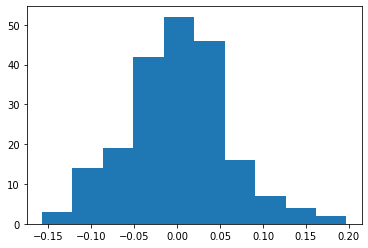

In [698]:
_ = plt.hist(before_minus_after_residual_df.values.ravel())

(array([1, 2, 3, 4, 5]), <a list of 5 Text xticklabel objects>)

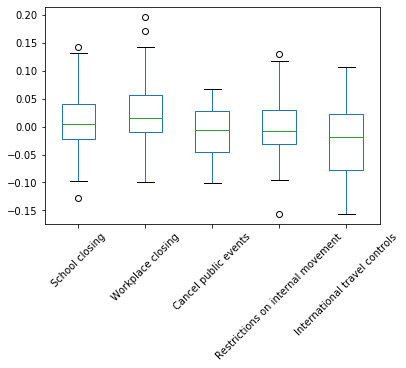

In [700]:
_ = before_minus_after_residual_df.plot.box()
plt.xticks(rotation=45)

In [201]:
start_names = start_end_filtered_df.columns[::2]
end_names = start_end_filtered_df.columns[1::2]

In [254]:
usa_responses_start = start_end_filtered_df.loc['United States', start_names].sort_index()
usa_responses_start.index = usa_responses_start.index.str.split('_').str.slice(stop=-1).str.join(sep=' ')

usa_responses_end = start_end_filtered_df.loc['United States', end_names].sort_index()
usa_responses_end.index = usa_responses_end.index.str.split('_').str.slice(stop=-1).str.join(sep=' ')

In [255]:
usa_responses_start

Cancel public events                2020-03-12
International travel controls       2020-02-02
Restrictions on internal movement   2020-03-14
School closing                      2020-03-03
Workplace closing                   2020-03-19
Name: United States, dtype: datetime64[ns]

In [256]:
until_next_measure_widths = np.abs(usa_responses_start.sort_values().diff(-1))
until_next_measure_widths.iloc[-1] = pd.Timedelta(seconds=0)
until_next_measure_widths

International travel controls       30 days
School closing                       9 days
Cancel public events                 2 days
Restrictions on internal movement    5 days
Workplace closing                    0 days
Name: United States, dtype: timedelta64[ns]

In [257]:
until_next_measure_widths = until_next_measure_widths.loc[usa_responses_start.sort_values().index]
until_next_measure_widths

International travel controls       30 days
School closing                       9 days
Cancel public events                 2 days
Restrictions on internal movement    5 days
Workplace closing                    0 days
Name: United States, dtype: timedelta64[ns]

In [270]:
amurica = data.loc['United States',['population','total_cases','total_cases_interpolated','tests_cumulative_interpolated']]

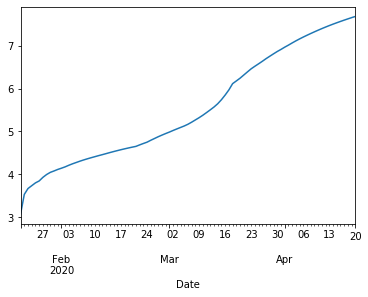

In [306]:
(amurica.total_cases_interpolated / ((amurica.population/1000000.) * (amurica.tests_cumulative_interpolated/100000.))).cumsum().apply(np.log).plot()

In [265]:
data.loc['United States',['total_cases','total_cases_interpolated','tests_cumulative_interpolated']]

,total_cases,total_cases_interpolated,tests_cumulative_interpolated
Date,,,
2019-12-31,NaN,1.0,4.0
2020-01-01,NaN,1.0,4.0
2020-01-02,NaN,1.0,4.0
2020-01-03,NaN,1.0,4.0
2020-01-04,NaN,1.0,4.0
...,...,...,...
2020-04-16,639664.0,639664.0,3262921.0
2020-04-17,671331.0,671331.0,3423034.0
2020-04-18,702164.0,702164.0,3574392.0


In [ ]:
data.loc['United States',['total_cases','total_cases_interpolated','tests_cumulative_interpolated']]

In [307]:
cumulative_normalized_case_data = (amurica.total_cases_interpolated / ((amurica.population/1000000.) * (amurica.tests_cumulative_interpolated/100000.))).cumsum().apply(np.log)#.plot()

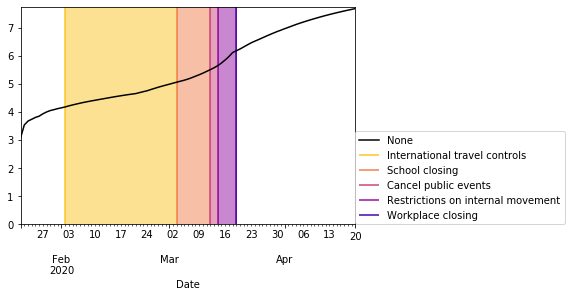

In [311]:
cmap = plt.get_cmap('plasma')
my_colors = [cmap(int(i)) for i in np.linspace(cmap.N-32, 32, len(usa_responses_start))]

fig, ax = plt.subplots()
cumulative_normalized_case_data.plot(ax=ax,color='k')
_, ymax = ax.get_ylim()
ymin = 0
for i, (df_index, df_val) in enumerate(usa_responses_start.sort_values().iteritems()):
    ax.vlines(df_val, ymin=ymin, ymax=ymax, label=df_index, color=my_colors[i])
    ax.add_patch(Rectangle((usa_responses_start.loc[df_index], 0),
                            until_next_measure_widths.loc[df_index], ymax, angle=0.0, color=my_colors[i], alpha=0.5))
ax.set_ylim([0, 0.98*ymax])
_ = plt.legend(loc=(1,0))
_ = plt.show()

30 days 00:00:00
9 days 00:00:00
2 days 00:00:00
5 days 00:00:00
0 days 00:00:00


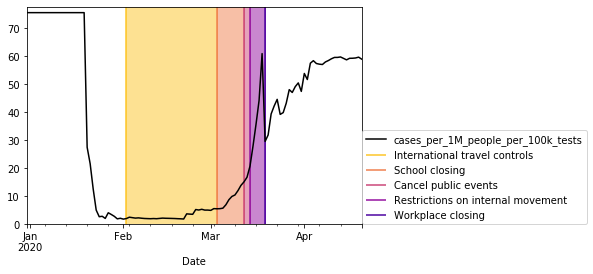

In [260]:

cmap = plt.get_cmap('plasma')
# my_colors = [cmap(int(i)) for i in np.linspace(cmap.N-32, 32, len(usa_responses_start))]

fig, ax = plt.subplots()
data.cases_per_1M_people_per_100k_tests.loc['United States'].plot(ax=ax,color='k')
ymin, ymax = ax.get_ylim()
for i, (df_index, df_val) in enumerate(usa_responses_start.sort_values().iteritems()):
    ax.vlines(df_val, ymin=ymin, ymax=ymax, label=df_index, color=my_colors[i])
    print(until_next_measure_widths.loc[df_index])
    ax.add_patch(Rectangle((usa_responses_start.loc[df_index], 0),
                            until_next_measure_widths.loc[df_index], ymax, angle=0.0, color=my_colors[i], alpha=0.5))
ax.set_ylim([0, 0.98*ymax])
_ = plt.legend(loc=(1,0))
_ = plt.show()

In [224]:
start_end_widths = (usa_responses_end-usa_responses_start).loc[usa_responses_start.sort_values().index]

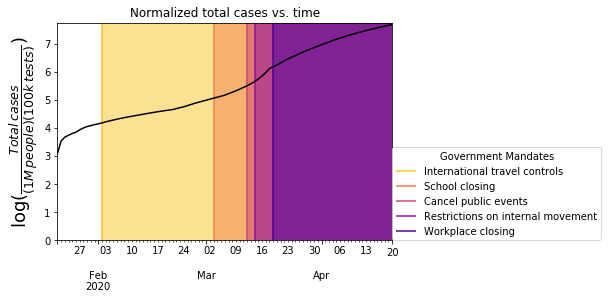

In [318]:
cmap = plt.get_cmap('plasma')
my_colors = [cmap(int(i)) for i in np.linspace(cmap.N-32, 32, len(usa_responses_start))]

fig, ax = plt.subplots()
cumulative_normalized_case_data.plot(ax=ax,color='k',label='')
_, ymax = ax.get_ylim()
ymin = 0
for i, (df_index, df_val) in enumerate(usa_responses_start.sort_values().iteritems()):
    ax.vlines(df_val, ymin=ymin, ymax=ymax, label=df_index, color=my_colors[i])
    ax.add_patch(Rectangle((usa_responses_start.loc[df_index], 0),
                            start_end_widths.loc[df_index], ymax, angle=0.0, color=my_colors[i], alpha=0.5))

ax.set_ylim([0, 0.98*ymax])
_ = plt.legend(loc=(1,0),title='Government Mandates')
_ = plt.xlabel('')
dmmy = plt.ylabel('$\\log(\\frac{Total\:cases}{(1M\,people)(100k\, tests)})$', fontsize=18)
_ = plt.title('Normalized total cases vs. time')
_ = plt.show()

In [ ]:
sliced_values_of_interest = sliced_values.loc[:, 'cases_per_1M_people']
sliced_values_of_interest

In [ ]:
sliced_values_of_interest = sliced_values.loc[:, 'cases_per_1M_people_per_100k_tests']#.replace(to_replace=np.nan, value=1.)
avg_case_rate = (1/len(sliced_values_of_interest))*np.log((sliced_values_of_interest.iloc[-1]/sliced_values_of_interest.iloc[0]))
return avg_case_rate

In [ ]:
testing_multiindex_df.index.get_level_values(0).unique()
testing_and_response_data_countries = start_end_filtered_df.index.intersection(testing_df.index.unique())

The testing data is being used as a reference, so its not necessary to remove the countries which aren't
in the government response data.

In [ ]:
start_end_filtered_df = start_end_filtered_df.loc[testing_and_response_data_countries,:]
enacted_ended_df_multiindex = enacted_ended_df_multiindex.loc[testing_and_response_data_countries,:]

Unfortunately there is one more step that needs to be taken, as even though the testing data has data on
some countries, it doesn't contain the actual testing data. Therefore, need to remove countries which do not
have testing data.

Countries where there is actual testing data and case data. 

Only look at the average growth rates after first known case, as to not unfairly decrease the rate before responses.

## Instead of datetime slicing I should have just been using days since first case.

In [ ]:
testing_after_first_known_case_df = testing_multiindex_df.loc[testing_multiindex_df.total_cases.replace(to_replace=0, value=np.nan).dropna().index,:]
testing_after_first_known_case_df.head()

In [ ]:
testing_country_list = testing_multiindex_df.index.get_level_values(level=0).unique()
final_country_list = start_end_filtered_final_df.index.intersection(testing_country_list)
final_country_list

In [ ]:
start_end_filtered_final_df = start_end_filtered_df.loc[final_country_list,:] 
enacted_ended_filtered_final_df = enacted_ended_filtered_df.loc[final_country_list,:] 

Redo the multiindex slice computation

In [ ]:
enacted_ended_df_multiindex_final = enacted_ended_filtered_final_df.copy()
for c in enacted_ended_filtered_final_df.columns:
    enacted_ended_df_multiindex_final.loc[:, c] = list(zip(enacted_ended_df_multiindex_final.index.tolist(), 
                                               enacted_ended_df_multiindex_final.loc[:, c].tolist()))

In [ ]:
def multi_index_slice_to_average_rate_original(x, testing_df):
    sliced_values = testing_df.loc[x, :]
    sliced_values_of_interest = sliced_values.loc[:, ['total_cases_per_million', 'total_tests']].replace(to_replace=np.nan, value=1.) 
#     avg_case_rate = (sliced_values_of_interest.iloc[-1, 0]
#                               -sliced_values_of_interest.iloc[0, 0])  / len(sliced_values_of_interest)
    avg_case_rate = (sliced_values_of_interest.iloc[-1, 0]/sliced_values_of_interest.iloc[0, 0])**(-1/len(sliced_values_of_interest))
#         test_weight = (sliced_values_of_interest.iloc[-1, 1]
#                        -sliced_values_of_interest.iloc[0, 1])
#         if (test_weight == 0.) or (test_weight == np.nan):
#             test_weight = 1.
#         weighted_avg_rate = avg_case_rate / test_weight
#         return weighted_avg_rate
    return avg_case_rate

These represent the official dates of government action but these dates may not exist in testing data. Therefore, need to check start dates vs. testing data start dates.

testing data typically starts far after response data. therefore cannot weight by testing and still have representation from majority of countries. In that case, just use the average rate of total cases per million, before and after response dates.

In [ ]:
start_end_testing_comparison_df = start_end_filtered_final_df.copy()

In [ ]:
first_response_dates = start_end_filtered_final_df.min(axis=1).sort_index()
first_response_dates.head(10)

In [ ]:
first_case_dates = testing_after_first_known_case_df.reset_index(level=1).groupby(level=0).date.min().sort_index()
first_case_dates.head(10)

In [ ]:
dates_with_test_data = testing_after_first_known_case_df.total_tests.dropna()
dates_with_test_data.head()

In [ ]:
min_testing_dates = testing_after_first_known_case_df.total_tests.dropna().reset_index(level=1).groupby(level=0).date.min()

In [ ]:
after_first_known_test = testing_after_first_known_case_df.loc[testing_after_first_known_case_df.total_tests.dropna().index,:]
after_first_known_test.loc[:, 'total_rate'] = after_first_known_test.total_cases / after_first_known_test.total_tests

In [ ]:
first_testing_dates = testing_after_first_known_case_df.total_tests.dropna().reset_index(level=1).groupby(level=0).date.min()
last_testing_dates = testing_after_first_known_case_df.total_tests.dropna().reset_index(level=1).groupby(level=0).date.max()

In [ ]:
# convert entire dataframe to index so it can be used to slice testing data, dataframe
first_tmp =  first_testing_dates.reset_index().set_index(['location','date'])
last_tmp =  last_testing_dates.reset_index().set_index(['location','date'])
first_tmp.head()

In [ ]:
test_min = testing_multiindex_df.loc[first_tmp.index, :]
test_max = testing_multiindex_df.loc[last_tmp.index, :]

In [ ]:
# reset index so we can subtract datetime variables.
test_max_reset = test_max.reset_index(level=1)
test_min_reset = test_min.reset_index(level=1)
time_differential = (test_max_reset.date - test_min_reset.date).dt.days
testing_rates = np.log(test_max_reset.total_tests / test_min_reset.total_tests) / time_intervals

Because modeling as exponential, the rate is given by $\frac{1}{\Delta t}\ln (\frac{test_f}{test_i}) = r$

In [ ]:
test_final_test_initial_time_intervals = (test_max_reset.date - test_min_reset.date).dt.days

In [ ]:
reset_tmp = testing_after_first_known_case_df.reset_index(level=1)
reset_tmp.loc[:,'time_differential'] = (reset_tmp.date-test_min_reset.date).dropna().dt.days.values

In [ ]:
reset_tmp.loc[test_min_reset.index,'initial_test_number'] = test_min_reset.total_tests

In [ ]:
idxslice = pd.IndexSlice['Argentina', testing_df.loc['Argentina',:].date.min():]
testing_multiindex_df.loc[idxslice,:].reset_index(level=0,drop=True).total_tests.plot(marker='.',linestyle='none',label='total tests, source 2',markersize=15,alpha=0.5,color='red')
new_testing_multiindex_df.loc[idxslice, :].reset_index(level=0,drop=True).tests_cumulative.plot(marker='.',linestyle='none',label='total tests, source 1',markersize=15,alpha=0.5)
_ =testing_multiindex_df.loc[idxslice,:].reset_index(level=0,drop=True).total_cases.plot(marker='.',linestyle='none',label='total cases',markersize=15,alpha=0.5)
plt.axvline(min_response_dates.loc['Argentina'], color='black', linewidth=5, label='first government action')
_ = plt.legend()
_ = plt.title('COVID-19 in Argentina')
_ = plt.ylabel('Cumulative total')
_ = plt.xlabel('')

Calculate the extrapolation range by comparing first known case date with first reported test date (obviously
there must to have been tests before this date, they just weren't recorded). More concerned with getting the extrapolation right, so don't worry if it doesn't match where there is actual testing data.

In [ ]:
case_response_differential = min_case_dates.loc[shared_index]-min_response_dates.loc[shared_index]

In [ ]:
negative_case_differential_index = case_response_differential.index.where(case_response_differential.dt.days < 0)

In [ ]:
case_testing_differential = min_case_dates.loc[shared_index]-min_testing_dates.loc[shared_index]
case_testing_differential

In [ ]:
final_index = negative_case_differential_index.dropna().intersection(start_end_filtered_final_df.index).intersection(testing_df.index.unique())

In [ ]:
start_end_final = start_end_filtered_final_df.loc[final_index, :]
slice_final = enacted_ended_df_multiindex_final.loc[final_index, :]
testing_final = testing_after_first_known_case_df.loc[final_index, :]

In [ ]:
average_rate_df = slice_final.copy()
for col in average_rate_df.columns:
    average_rate_df.loc[:, col] = average_rate_df.loc[:, col].apply(multi_index_slice_to_average_rate, args=(testing_final, ))

In [ ]:
#slice_final.iloc[:,0].apply(multi_index_slice_to_average_rate, args=(testing_final, ))

In [ ]:
#enacted_ended_df_multiindex_final.iloc[:,0].apply(multi_index_slice_to_average_rate, args=(testing_multiindex_df_tmp, ))

Convert the testing dataframe to the same standard of country names then slice out all countries that are not in
the current pool of names. 

slice the countries to those our reduced set.

In [ ]:
dir(slice)

In [ ]:
global_cases = '.\\COVID-19\\csse_covid_19_data\\csse_covid_19_time_series\\time_series_covid19_confirmed_global.csv'
g = pd.read_csv(global_cases)

In [ ]:
IHME_data = pd.read_csv('./ihme-covid19/2020_04_12.02/Hospitalization_all_locs.csv')

In [ ]:
dir_ =  'C:\\Users\\Matt\\Desktop\\statmethods\\group_project\\COVID-19\\csse_covid_19_data\\csse_covid_19_daily_reports\\format0\\'
file = dir_ + '01-23-2020.csv'

In [ ]:
dir_ =  'C:\\Users\\Matt\\Desktop\\statmethods\\group_project\\COVID-19\\csse_covid_19_data\\csse_covid_19_daily_reports\\format0\\'
file = dir_ + '01-23-2020.csv'

In [ ]:
dir0 = '.\\COVID-19\\csse_covid_19_data\\csse_covid_19_daily_reports\\format0\\'
dir1 = '.\\COVID-19\\csse_covid_19_data\\csse_covid_19_daily_reports\\format1\\'
dir2 = '.\\COVID-19\\csse_covid_19_data\\csse_covid_19_daily_reports\\format2\\'

In [ ]:
uc =  '.\\COVID-19\\csse_covid_19_data\\csse_covid_19_time_series\\time_series_covid19_confirmed_US.csv'
ud =  '.\\COVID-19\\csse_covid_19_data\\csse_covid_19_time_series\\time_series_covid19_deaths_US.csv'

In [ ]:
us_cases = pd.read_csv(uc)
us_deaths = pd.read_csv(ud)
us_deaths['type']='Dead'
us_cases['type']='Confirmed'

In [ ]:
pd.concat((us_cases, us_deaths)).sort_index(axis=1).iloc[:, -13:]

In [ ]:
us_deaths.set_index('Province_State').loc[:, '1/22/20':].groupby(level=0).sum()

In [ ]:
dead=us_deaths[us_deaths['Province_State'].isin(['Michigan', 'Georgia', 'New York'])].groupby(by='Province_State').sum().loc[:,'1/22/20':]#.iloc[:, 4:].transpose().columns
confirmed=us_cases[us_cases['Province_State'].isin(['Michigan', 'Georgia', 'New York'])].groupby(by='Province_State').sum().loc[:,'1/22/20':]
confirmed.head()

In [ ]:
rate = dead / confirmed

In [ ]:
fig = plt.figure(figsize=(10,10), dpi=200)
(100*rate.loc[:, '2/21/20':]).transpose().plot().legend(bbox_to_anchor=(1, 1))
_ = plt.xlabel('Date')
_ = plt.ylabel('Death Rate (%)')
plt.grid(True, axis='both')
plt.title('Death rate by state')
plt.savefig('death_rate_NY_MI_GA.png', bbox_inches='tight')

In [ ]:
fig, (ax,ax2) = plt.subplots(1, 2, sharey=True,  figsize=(20,5), dpi=200)
confirmed.loc[:, '2/21/20':].transpose().plot(ax=ax).legend(bbox_to_anchor=(0.2, 1))
dead.loc[:, '2/21/20':].transpose().plot(ax=ax2).legend(bbox_to_anchor=(0.2, 1))
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_title('Number of confirmed cases vs. time')
ax2.set_title('Number of diseased vs. time')
ax.grid(True, axis='both')
ax2.grid(True, axis='both')
plt.savefig('cases_vs_dead_comparison_GA_NY_MI.png', bbox_inches='tight')

In [ ]:
testdat = pd.read_csv('full-list-cumulative-total-tests-per-million.csv')
testdat

In [ ]:
def top_5_counties(state_df, state_name):
    state = state_df[(state_df.Province_State==state_name)]
    state = state.drop(columns=['UID','iso2','iso3','code3','FIPS','Country_Region','Lat','Long_','Combined_Key','Province_State'])
    top5_counties = state.groupby(by='Admin2').sum().sum(axis=1).sort_values(ascending=False)[:5].index.tolist()
    state_info = state[state.Admin2.isin(top5_counties)].set_index('Admin2').transpose()
    state_info.columns.name = 'County'
    return state_info

In [ ]:
not_of_interest = ['UID','iso2','iso3','code3','FIPS','Admin2','Country_Region','Lat','Long_','Combined_Key']

In [ ]:
mich = u[(u.Province_State=='Michigan')]
mich = mich.drop(columns=['UID','iso2','iso3','code3','FIPS','Country_Region','Lat','Long_','Combined_Key','Province_State'])

In [ ]:
michtop5_counties = mich.groupby(by='Admin2').sum().sum(axis=1).sort_values(ascending=False)[:5].index.tolist()

In [ ]:
fig, (ax,ax2) = plt.subplots(1, 2, figsize=(20,5), sharey=True)
top_5_counties(u, 'Michigan').plot(ax=ax)
top_5_counties(u, 'New York').plot(ax=ax2)
_ = plt.yscale('log')
_ = plt.xlabel('Date')
_ = plt.ylabel('No. Cases')

In [ ]:
top_5_counties(u, 'Michigan').sum(axis=1)

In [ ]:
top_5_counties(u, 'Michigan').transpose().replace(0, np.nan).bfill(1).iloc[:, 0]

In [ ]:
timeseries = pd.concat((top_5_counties(u, 'New York').loc['3/2/20':, :], top_5_counties(u, 'Michigan').loc['3/11/20':, :]),axis=1).replace(to_replace=0, value=np.nan)

In [ ]:
rotations = timeseries.isna().sum().tolist()

timeseries2 = timeseries.copy()
for i, c in enumerate(timeseries2.columns):
    timeseries2[c]=np.roll(timeseries2[c], -rotations[i],axis=0)

In [ ]:
tmp = timeseries2.Oakland
timeseries2=timeseries2.drop(columns='Oakland')

In [ ]:
ax = timeseries2.reset_index(drop=True).plot()#.legend()
_  = tmp.reset_index(drop=True).plot(color='r', ax=ax, linewidth=6, label='Oakland')
plt.legend(bbox_to_anchor=(1, 1))
_ = plt.yscale('log')
_ = plt.ylabel('No. Cases')
_ = plt.xlabel('Days since first recorded case')
_ = plt.title('COVID growth in top five counties from NY and MI')

In [ ]:
ax = timeseries2.reset_index(drop=True).plot()#.legend(bbox_to_anchor=(1, 1))
_  = tmp.reset_index(drop=True).plot(color='r', ax=ax, linewidth=6,label='Oakland')
plt.legend()
_ = plt.ylabel('No. Cases')
_ = plt.xlabel('Days since first recorded case')
_ = plt.title('COVID growth in top five counties from NY and MI')

In [ ]:
top_5_counties(u, 'New York').transpose().replace(0, np.nan).bfill(1).iloc[:, 0]

In [ ]:
# fig = plt.figure()
ax = top_5_counties(u, 'Michigan').plot(figsize=(10,10))
top_5_counties(u, 'New York').plot(ax=ax)
_ = plt.yscale('log')
_ = plt.xlabel('Date')
_ = plt.ylabel('No. Cases')

In [ ]:
compare = u[(u.Province_State=='Michigan') | (u.Province_State=='New York') | (u.Province_State=='Georgia')]
ctest = compare.drop(columns=not_of_interest).groupby('Province_State').sum().transpose()#.plot()
_ = ctest.plot()
plt.yscale('log')

In [ ]:
ctest2.reset_index(drop=True).plot().legend(bbox_to_anchor=(1, 1))
_ = plt.yscale('log')
_ = plt.ylabel('No. Cases')
_ = plt.xlabel('Days since first recorded case')
_ = plt.title('COVID growth in GA, MI, NY')

In [ ]:
fig, (ax,ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax.plot(nedcf, label='New York')
ax.plot(medcf, label='Michigan')
_ = ax.legend()
ax.set_ylabel('No. Cases')
ax.set_xlabel('No. days since first recorded case')

ax2.plot(nedcf, label='New York')
ax2.plot(medcf, label='Michigan')
_ = ax2.legend()
ax2.set_ylabel('No. Cases')
ax2.set_xlabel('No. days since first recorded case')
ax2.set_yscale('log')

In [ ]:
stateagg = compare.drop(columns=not_of_interest).groupby('Province_State').sum().astype(float)#.apply(np.log10)
stateagg.index.name = None

In [ ]:
mval = stateagg.transpose().values[:, 0]
nval = stateagg.transpose().values[:, 1]

In [ ]:
nedcf = nval[-31:]

In [ ]:
medcf = np.roll(mval,-8)[-31:]

In [ ]:
medcf[np.where(medcf==0)]=np.nan

In [ ]:
fig, (ax,ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax.plot(nedcf, label='New York')
ax.plot(medcf, label='Michigan')
_ = ax.legend()
ax.set_ylabel('No. Cases')
ax.set_xlabel('No. days since first recorded case')

ax2.plot(nedcf, label='New York')
ax2.plot(medcf, label='Michigan')
_ = ax2.legend()
ax2.set_ylabel('No. Cases')
ax2.set_xlabel('No. days since first recorded case')
ax2.set_yscale('log')

In [ ]:
not_of_interest = ['UID','iso2','iso3','code3','FIPS','Admin2','Country_Region','Lat','Long_','Combined_Key']

In [ ]:
gc = '.\\COVID-19\\csse_covid_19_data\\csse_covid_19_time_series\\time_series_covid19_confirmed_global.csv'
gd = '.\\COVID-19\\csse_covid_19_data\\csse_covid_19_time_series\\time_series_covid19_deaths_global.csv'
gr = '.\\COVID-19\\csse_covid_19_data\\csse_covid_19_time_series\\time_series_covid19_recovered_global.csv'

In [ ]:
global_confirmed = pd.read_csv(gc)
global_dead = pd.read_csv(gd)
global_recovered = pd.read_csv(gr)

In [ ]:
global_recovered_dates_only = global_recovered.set_index('Country/Region').loc[:, '1/22/20':].groupby(level=0).sum()
global_confirmed_dates_only = global_confirmed.set_index('Country/Region').loc[:, '1/22/20':].groupby(level=0).sum()
global_dead_dates_only = global_dead.set_index('Country/Region').loc[:, '1/22/20':].groupby(level=0).sum()

In [ ]:
global_dead['type']='Dead'
global_confirmed['type']='Confirmed'
global_recovered['type']='Recovered'

In [ ]:
dead=global_dead[global_dead['Country/Region'].isin(['Germany', 'Italy', 'US'])].set_index('Country/Region').loc[:,'1/22/20':]#.iloc[:, 4:].transpose().columns
confirmed=global_confirmed[global_confirmed['Country/Region'].isin(['Germany', 'Italy', 'US'])].set_index('Country/Region').loc[:,'1/22/20':]#.iloc[:, 4:].transpose().columns

In [ ]:
rate = dead/confirmed

In [ ]:
(100*rate.loc[:, '2/21/20':]).transpose().plot().legend(bbox_to_anchor=(1, 1))
_ = plt.xlabel('Date')
_ = plt.ylabel('Death Rate (%)')
plt.grid(True, axis='both')
plt.title('Death rate by country')
plt.savefig('death_rate_GR_ITA_USA.png', bbox_inches='tight')

In [ ]:
global_dead = global_dead.sort_index(axis=1)
global_confirmed = global_confirmed.sort_index(axis=1)
global_recovered = global_recovered.sort_index(axis=1)

In [ ]:
g11.plot(figsize=(10,10)).legend(bbox_to_anchor=(1, 1))
plt.yscale('log')
plt.ylabel('No. Cases')
plt.xlabel('Date')
plt.grid(True, axis='both')
plt.title('Top 10 countries (+ South Korea) by case number')
plt.savefig('top_10_countries.png', bbox_inches='tight')

In [ ]:
dsum = global_dead_dates_only.sum()
csum = global_confirmed_dates_only.sum()
drsum = 100*dsum/csum
drsum.plot()
_ = plt.xlabel('Date')
_ = plt.ylabel('Death Rate (%)')
_ = plt.title('Average global death rate vs. time')
plt.grid(True, axis='both')
plt.savefig('death_rate_global.png', bbox_inches='tight')

In [ ]:
split_data = re.split(pattern='N2O\S+yr', string=data)[1]
df_tmp = pd.read_csv(StringIO(split_data), 
             sep=('\s+'), 
             skiprows=1, 
                 usecols=[0,1,2,3,4,5], 
             engine='python')

for i, f in enumerate(glob.glob('.\\N2O\\*')):
    with open(f, 'r') as file:
        data = file.read()
    split_data = ''.join(re.split(pattern=r'(N2O\S+yr)', string=data)[1:])
    df_tmp = pd.read_csv(StringIO(split_data), 
                 sep=('\s+'), 
#                 skiprows=1, 
#                 usecols=[0,1,2,3,4,5], 
                 engine='python')
    df_tmp.index = pd.to_datetime(df_tmp.iloc[:,0].astype(str) + '-' 
                                  + df_tmp.iloc[:,1].astype(str) + '-' 
                                  + df_tmp.iloc[:,2].astype(str))
    df_tmp.drop(columns=df_tmp.columns.tolist()[:3], inplace=True)
    if i == 0:
        n2o = df_tmp
    else:
        n2o = n2o.join(df_tmp, how='inner')
    
